# EEG data classification Guinnea Bissau

This notebook contains experiments with an EEG dataset. The classes are Epilepsy: 0 or Control 1.

Load dependences and setting output configuration

In [2]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
%pylab inline
%load_ext autoreload
%autoreload 2

Using Theano backend.


Populating the interactive namespace from numpy and matplotlib


## Load data from npy files

Specify location of npy files:

In [4]:
datapath = '/media/windows-share/EEGs_Guinea-Bissau_np/'
#datapath = '/media/sf_VBox_Shared/timeseries/EEGs_Guinea-Bissau_np/'#

Load data stored in 10 seconds at 128 Hertz corresponding to the experiment where the participant had the eyes closed:

In [5]:
condition = '_10seconds_closed.npy'
X_train = np.load(datapath+'X_train'+condition)
y_train = np.load(datapath+'y_train'+condition)
X_val = np.load(datapath+'X_valid'+condition)
y_val = np.load(datapath+'y_valid'+condition)
X_test = np.load(datapath+'X_test'+condition)
y_test = np.load(datapath+'y_test'+condition)

In [6]:
classlabels = list(set(y_train))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
print(mapclasses)

{'Epilepsy': 0, 'Control': 1}


In [7]:
y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_test], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

In [8]:
y_val_binary

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

## Generate models

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from mcfly import modelgen, find_architecture

In [10]:
np.random.seed = 321
num_classes = y_train_binary.shape[1]

In [11]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 2,
                                  model_type = 'CNN',
                                  cnn_min_layers=2,
                                  cnn_max_layers=5,
                                 low_lr=2, high_lr=8)

CPU times: user 2.12 s, sys: 500 ms, total: 2.62 s
Wall time: 3.49 s


In [12]:
%%time
for model, params, model_types in models:
    print(params)
    model.summary()

{'fc_hidden_nodes': 494, 'regularization_rate': 0.00011521852358350661, 'filters': array([54, 33]), 'learning_rate': 1.1388462194153422e-08}
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
batchnormalization_1 (BatchNormaliz(None, 1280, 14)    28          batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)    (None, 1280, 54)    2322        batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNormaliz(None, 1280, 54)    108         convolution1d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)          (None, 1280, 54)

## Compare models

Currently run with a very low number of epochs

In [13]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=3,
                                                                                  subset_size=200,
                                                                                  verbose=True)

Training model 0 CNN
Train on 108 samples, validate on 20 samples
Epoch 1/3
108/108 [==============================] - 4s - loss: 0.8933 - acc: 0.5185 - val_loss: 4.1010 - val_acc: 0.5500
Epoch 2/3
108/108 [==============================] - 3s - loss: 0.9034 - acc: 0.4630 - val_loss: 1.7030 - val_acc: 0.5500
Epoch 3/3
108/108 [==============================] - 3s - loss: 0.9149 - acc: 0.4907 - val_loss: 1.1376 - val_acc: 0.5500
Training model 1 CNN
Train on 108 samples, validate on 20 samples
Epoch 1/3
108/108 [==============================] - 6s - loss: 3.9281 - acc: 0.4815 - val_loss: 5.0274 - val_acc: 0.4500
Epoch 2/3
108/108 [==============================] - 6s - loss: 4.0054 - acc: 0.4630 - val_loss: 2.2598 - val_acc: 0.4500
Epoch 3/3
108/108 [==============================] - 7s - loss: 3.9462 - acc: 0.4167 - val_loss: 0.9289 - val_acc: 0.4000
CPU times: user 55.6 s, sys: 21.1 s, total: 1min 16s
Wall time: 1min 18s


CPU times: user 260 ms, sys: 16 ms, total: 276 ms
Wall time: 313 ms


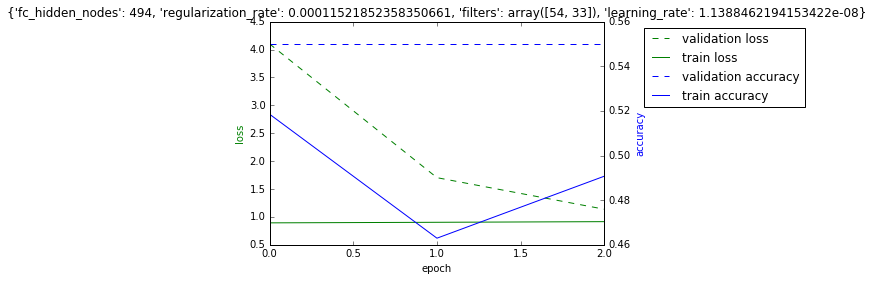

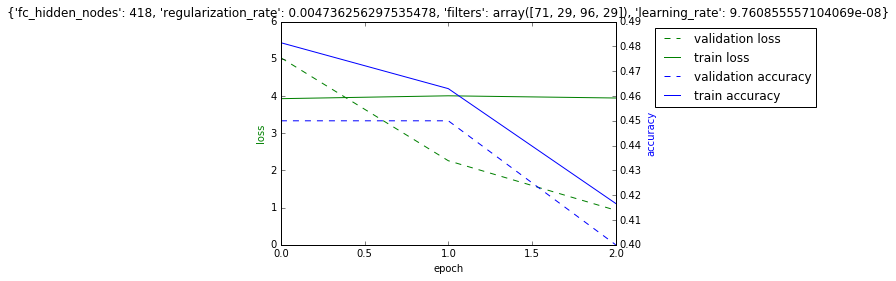

In [14]:
%%time
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)

In [15]:
#%%time
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'fc_hidden_nodes': 494, 'regularization_rate'...",0.490741,0.914856,0.55,1.137594
1,"{'fc_hidden_nodes': 418, 'regularization_rate'...",0.416667,3.946226,0.40,0.928925


## Train the best model for real

In [16]:
best_model_index = np.argmax(val_accuracies)
#best_model_index = np.argmax(val_losses)
#best_model_index = 1

In [17]:
import theano
theano.config.mode

'Mode'

In [18]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

0 CNN {'fc_hidden_nodes': 494, 'regularization_rate': 0.00011521852358350661, 'filters': array([54, 33]), 'learning_rate': 1.1388462194153422e-08}


In [19]:
best_model_copy = modelgen.generate_CNN_model(X_train.shape, num_classes, best_params['filters'], best_params['fc_hidden_nodes'],
                       best_params['learning_rate'], best_params['regularization_rate'])
best_model_copy = best_model
print(best_model_index, best_model_types, best_params)

0 CNN {'fc_hidden_nodes': 494, 'regularization_rate': 0.00011521852358350661, 'filters': array([54, 33]), 'learning_rate': 1.1388462194153422e-08}


In [20]:
nr_epochs = 10
datasize = X_train.shape[0]#1000
history = best_model_copy.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary), batch_size=20)

Train on 108 samples, validate on 20 samples
Epoch 1/10
108/108 [==============================] - 4s - loss: 0.9228 - acc: 0.4722 - val_loss: 0.9146 - val_acc: 0.5000
Epoch 2/10
108/108 [==============================] - 3s - loss: 0.8665 - acc: 0.4630 - val_loss: 0.9016 - val_acc: 0.4500
Epoch 3/10
108/108 [==============================] - 4s - loss: 0.9231 - acc: 0.4074 - val_loss: 0.8758 - val_acc: 0.4500
Epoch 4/10
108/108 [==============================] - 4s - loss: 0.8892 - acc: 0.5000 - val_loss: 0.8773 - val_acc: 0.4000
Epoch 5/10
108/108 [==============================] - 5s - loss: 0.9199 - acc: 0.4907 - val_loss: 0.8669 - val_acc: 0.4000
Epoch 6/10
108/108 [==============================] - 4s - loss: 0.8658 - acc: 0.5648 - val_loss: 0.8668 - val_acc: 0.4500
Epoch 7/10
108/108 [==============================] - 4s - loss: 0.8660 - acc: 0.5370 - val_loss: 0.8562 - val_acc: 0.5000
Epoch 8/10
108/108 [==============================] - 4s - loss: 0.9108 - acc: 0.4537 - val_lo

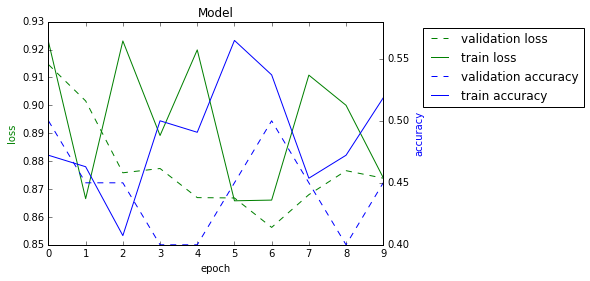

In [21]:
find_architecture.plotTrainingProcess(history)

## Inspect model predictions

In [22]:
datasize = X_val.shape[0]
best_model_copy.predict_proba(X_val[:datasize,:,:],batch_size=1)

20/20 [==============================] - 1s     


array([[ 0.96081418,  0.03918583],
       [ 0.35405383,  0.64594615],
       [ 0.74747181,  0.25252816],
       [ 0.74191487,  0.2580851 ],
       [ 0.38060015,  0.61939985],
       [ 0.30543715,  0.69456285],
       [ 0.57504642,  0.42495358],
       [ 0.97367489,  0.02632511],
       [ 0.3674922 ,  0.6325078 ],
       [ 0.29981661,  0.70018339],
       [ 0.3696461 ,  0.63035393],
       [ 0.51115769,  0.48884231],
       [ 0.4917815 ,  0.50821847],
       [ 0.41921923,  0.5807808 ],
       [ 0.35314971,  0.64685029],
       [ 0.46234444,  0.53765559],
       [ 0.5215221 ,  0.4784779 ],
       [ 0.38273174,  0.61726826],
       [ 0.54752696,  0.45247301],
       [ 0.35230914,  0.64769083]])

In [23]:
best_model_copy.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
batchnormalization_1 (BatchNormaliz(None, 1280, 14)    28          batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)    (None, 1280, 54)    2322        batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNormaliz(None, 1280, 54)    108         convolution1d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)          (None, 1280, 54)    0           batchnormalization_2[0][0]       
___________________________________________________________________________________________

In [24]:
from keras import backend as K

# with a Sequential model
get_dens_layer_output = K.function([best_model_copy.layers[0].input, K.learning_phase()],
                                  [best_model_copy.layers[0].output])
layer_output = get_dens_layer_output([X_val, 0])[0]

In [25]:
layer_output.shape

(20, 1280, 14)

In [26]:
layer_output.mean(axis=(0,1))

array([ 0.04374453,  0.03834507, -0.00891328, -0.04491771,  0.0457358 ,
       -0.04177089,  0.02530164,  0.06146864,  0.06281064, -0.01103885,
       -0.03286022,  0.10070235,  0.07257555, -0.03934217], dtype=float32)

In [27]:
layer = best_model.layers[0]
for w in layer.get_weights():
    print(w.shape)

(14,)
(14,)
(14,)
(14,)


## See if we can overfit on a small train set

In [28]:
params = models[0][1]
print(params)
small_model = modelgen.generate_CNN_model(X_train.shape, num_classes, params['filters'], params['fc_hidden_nodes'],
                                  0.01, #params['learning_rate'], 
                                        regularization_rate=0)
small_model.summary()

{'fc_hidden_nodes': 494, 'regularization_rate': 0.00011521852358350661, 'filters': array([54, 33]), 'learning_rate': 1.1388462194153422e-08}
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
batchnormalization_15 (BatchNormali(None, 1280, 14)    28          batchnormalization_input_4[0][0] 
____________________________________________________________________________________________________
convolution1d_9 (Convolution1D)    (None, 1280, 54)    2322        batchnormalization_15[0][0]      
____________________________________________________________________________________________________
batchnormalization_16 (BatchNormali(None, 1280, 54)    108         convolution1d_9[0][0]            
____________________________________________________________________________________________________
activation_15 (Activation)         (None, 1280, 54)

In [29]:
small_model.evaluate(X_val, y_val_binary)

20/20 [==============================] - 0s


[8.8649530410766602, 0.44999998807907104]

In [30]:
nr_epochs = 100
datasize = 20
history = small_model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary), batch_size=10)

Train on 20 samples, validate on 20 samples
Epoch 1/100
20/20 [==============================] - 1s - loss: 0.7206 - acc: 0.6500 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 2/100
20/20 [==============================] - 1s - loss: 0.4345 - acc: 0.9000 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 3/100
20/20 [==============================] - 1s - loss: 0.3407 - acc: 0.9000 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 4/100
20/20 [==============================] - 1s - loss: 0.3104 - acc: 0.9500 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 5/100
20/20 [==============================] - 1s - loss: 0.4919 - acc: 0.8000 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 6/100
20/20 [==============================] - 1s - loss: 0.2815 - acc: 1.0000 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 7/100
20/20 [==============================] - 1s - loss: 0.2746 - acc: 1.0000 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 8/100
20/20 [==============================] - 1s - loss: 0.4079 - acc: 0.8000 - val_loss: 7.253

## Test on Testset

In [33]:
score_test = best_model.evaluate(X_test, y_test_binary, verbose=False)
print('Score of best model: ' + str(score_test))

Score of best model: [0.96918404102325439, 0.5]


In [34]:
best_model.get_config()[0]

{'class_name': 'BatchNormalization',
 'config': {'axis': 2,
  'batch_input_shape': (None, 1280, 14),
  'epsilon': 1e-06,
  'input_dtype': 'float32',
  'mode': 0,
  'momentum': 0.9,
  'name': 'batchnormalization_1',
  'trainable': True}}